In [35]:
import numpy as np
import pandas as pd
import requests, zipfile, io, os
import json, glob, re, tmdb
from importlib import reload
from utils import create_directory, update_progress
import time
import shutil
from IPython.display import Image 

In [27]:
tmdb_api_key = "a67ce78b9ac0e0f7df8c2fc16c2fd30a"

In [18]:
with open("data/features.json", "r") as f:
    text_features = json.load(f)

all_movies = [json.loads(movie_str) for movie_str in text_features]
df_features = pd.DataFrame(all_movies)

In [21]:
links = pd.read_csv("data/links.csv", dtype={"tmdb_id": "Int64"})

In [22]:
links_full = links[~links.tmdb_id.isna()][["movie_id", "tmdb_id"]]

In [23]:
df_item_features = pd.merge(left=df_features, right=links_full, left_on="id", right_on="tmdb_id", how="left")

In [24]:
df_item_features.head()

,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,imdb_id,origin_country,original_language,...,tagline,title,video,vote_average,vote_count,success,status_code,status_message,movie_id,tmdb_id
0,False,/3Rfvhy1Nl6sSGJwyjb0QiZzZYlB.jpg,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000.0,"[{'id': 16, 'name': 'Animation'}, {'id': 12, '...",http://toystory.disney.com/toy-story,862.0,tt0114709,[US],en,...,Hang on for the comedy that goes to infinity a...,Toy Story,False,7.968,18757.0,NaN,NaN,NaN,1.0,862
1,False,/vm7yMg7YiYisMSeO3mUC5NUKbSB.jpg,"{'id': 645, 'name': 'James Bond Collection', '...",60000000.0,"[{'id': 12, 'name': 'Adventure'}, {'id': 28, '...",https://mgm.com/movies/goldeneye,710.0,tt0113189,[GB],en,...,No limits. No fears. No substitutes.,GoldenEye,False,6.900,3990.0,NaN,NaN,NaN,2.0,710
2,False,/f2t4JbUvQIjUF5FstG1zZFAp02N.jpg,None,4000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 80, 'nam...",https://www.miramax.com/movie/four-rooms/,5.0,tt0113101,[US],en,...,Twelve outrageous guests. Four scandalous requ...,Four Rooms,False,5.859,2686.0,NaN,NaN,NaN,3.0,5
3,False,/7KpwYPe6DfxutCFzJRpaTPtFu2o.jpg,"{'id': 91698, 'name': 'Chili Palmer Collection...",30250000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 53, 'nam...",,8012.0,tt0113161,[US],en,...,Attitude plays a part.,Get Shorty,False,6.495,1090.0,NaN,NaN,NaN,4.0,8012
4,False,/f0wTYitK1lELuGygXslG7SQpY0E.jpg,None,20000000.0,"[{'id': 53, 'name': 'Thriller'}, {'id': 80, 'n...",,1710.0,tt0112722,[US],en,...,One man is copying the most notorious killers ...,Copycat,False,6.507,995.0,NaN,NaN,NaN,5.0,1710


In [25]:
df_item_features.to_csv("data/item_features.csv", index=None)

In [26]:
create_directory("/data/posters")

Successfully created directory d:\Work\Development\recommendation_system/data/posters


In [32]:
def poster(movie_id, df):
    """
    Gets the movie poster from the movie_id
    
    poster_path (string): path for the poster
    df (pd.Dataframe): pandas dataframe with movie id and poster_path
    """
    directory_path = "data/posters/"    
    poster_path = df[df.movie_id == movie_id].poster_path.values[0]
    if poster_path == None:
        poster_path = ""
    
    save_path = directory_path + str(movie_id) + ".jpg"
    
    base_url = "https://image.tmdb.org/t/p/w92"
    url = base_url + poster_path + f"?api_key={tmdb_api_key}" 
    
    response = requests.request("GET", url, stream=True)
    if response.status_code == 200:
        with open(save_path, 'wb') as out_file:
            response.raw.decode_content = True 
            shutil.copyfileobj(response.raw, out_file)
        return True
    else: 
        return False

In [33]:
poster(1, df_item_features)

True

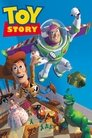

In [39]:
Image(filename='data/posters/1.jpg')

# Refine the data

In [40]:
items_raw = pd.read_csv("data/items_raw.csv")
item_features = pd.read_csv("data/item_features.csv")

In [42]:
items_raw["release_date"] = pd.to_datetime(items_raw.release_date)
items_raw["year"] = items_raw.release_date.apply(lambda x: str(x.year))

In [43]:
items_main = items_raw.drop(['video_release_date', 'release_date', 'imdb_url'], axis=1).copy()

In [44]:
items_addtl = item_features[['overview', 'original_language', 'runtime', 'vote_average', 'vote_count', "movie_id"]].copy()

In [45]:
items = pd.merge(left=items_main, right=items_addtl, on="movie_id", how="left")

In [47]:
items.head()

,movie_id,title,genre_unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,SciFi,Thriller,War,Western,year,overview,original_language,runtime,vote_average,vote_count
0,1,Toy Story (1995),0,0,0,1,1,1,0,0,...,0,0,0,0,1995,"Led by Woody, Andy's toys live happily in his ...",en,81.0,7.968,18757.0
1,2,GoldenEye (1995),0,1,1,0,0,0,0,0,...,0,1,0,0,1995,When a powerful satellite system falls into th...,en,130.0,6.900,3990.0
2,3,Four Rooms (1995),0,0,0,0,0,0,0,0,...,0,1,0,0,1995,It's Ted the Bellhop's first night on the job....,en,98.0,5.859,2686.0
3,4,Get Shorty (1995),0,1,0,0,0,1,0,0,...,0,0,0,0,1995,Chili Palmer is a Miami mobster who gets sent ...,en,105.0,6.495,1090.0
4,5,Copycat (1995),0,0,0,0,0,0,1,0,...,0,1,0,0,1995,An agoraphobic psychologist and a female detec...,en,124.0,6.507,995.0


In [48]:
items.to_csv("data/items.csv", index=None)

# Users

In [51]:
import spacy
from spacy.lang.en.examples import sentences 

nlp = spacy.load('en_core_web_lg')
doc = nlp(sentences[0])
print(doc.text)
for token in doc:
    print(token.text, token.pos_, token.dep_)

Apple is looking at buying U.K. startup for $1 billion
Apple PROPN nsubj
is AUX aux
looking VERB ROOT
at ADP prep
buying VERB pcomp
U.K. PROPN dobj
startup VERB advcl
for ADP prep
$ SYM quantmod
1 NUM compound
billion NUM pobj


In [52]:
tokens = nlp(u'dog cat banana')

In [53]:
for token1 in tokens:
    for token2 in tokens:
        print(token1.text, token2.text, token1.similarity(token2))

dog dog 1.0
dog cat 0.8016854524612427
dog banana 0.2432764321565628
cat dog 0.8016854524612427
cat cat 1.0
cat banana 0.28154364228248596
banana dog 0.2432764321565628
banana cat 0.28154364228248596
banana banana 1.0


In [54]:
import umap
from sklearn.datasets import load_digits

digits = load_digits()

embedding = umap.UMAP().fit_transform(digits.data)

d:\Work\Development\recommendation_system\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
d:\Work\Development\recommendation_system\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
